(150, 6, 10)


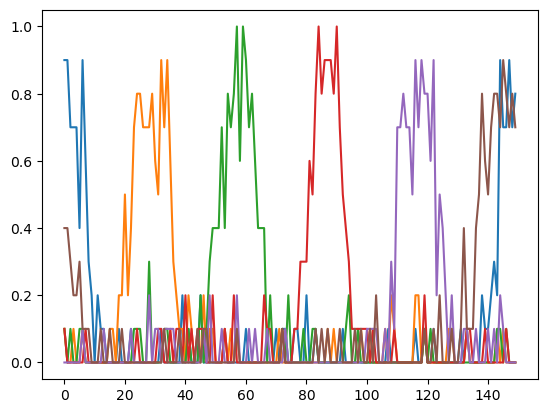

In [38]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


state_history = np.load('reports/state_history_20250521_173323.npy')
# neural_array = state_history['neuron_centric']
# print('[number_angles, number_trials, length_run]', state_history['metadata'])

# state_history = np.load('reports/state_history_2025052_203035.npy')
neural_array = state_history


print(neural_array.shape)
plt.plot(np.mean(neural_array,axis = -1))

In [39]:
# Now I have to come up with a way of defining the s

In [40]:
def compute_signal_vectors(response):
    """
    Compute Δμ for each ROI, SF, and pair of angles.
    response: (n_rois, n_angles, n_trials)
    Returns:
      Δμ: (n_rois, n_angles, n_angles)
    """
    # average over the chosen time window
    # average over trials
    mean_resp = np.nanmean(response, axis=-1)             # → (n_rois, n_angles)
    # subtract pairwise to get Δμ[:, i, j]
    dm = mean_resp[:, :, None] - mean_resp[:, None, :]     # → (n_rois, n_angles, n_angles)
    return dm  # shape (n_rois, n_angles, n_angles)

def compute_preferred_angles(response):
    """
    response: (n_rois, n_angles, n_trials)
    Returns:
        preferred_idx: (n_rois) giving for each neuron the preferred angle
    """
    # 1) average over trials and time
    rm = np.nanmean(response, axis=-1)             # → (n_rois, n_angles)
    n_angles = rm.shape[1]
    angles = np.arange(n_angles)
    preferred_idx = np.argmax(rm, axis=1)  # preferred angle for each neuron
    return preferred_idx  # shape (n_rois)


def compute_noise_metrics(response, signal_vectors, total_k=20):
    """
    response:       (n_rois, n_angles, n_trials)
    signal_vectors: (n_rois, n_angles, n_angles)

    Returns dict with:
      dot_prod       (n_angles, n_angles-1, total_k)
      top_evals      (n_angles, total_k)
      noise_corr     (n_angles,)
      mean_dist      (n_angles, n_angles-1)
      pc_coeff_pref  (n_rois, total_k)
    """
    resp = response  # (n_rois, n_angles, n_trials)
    n_rois, n_angles, n_trials = resp.shape

    dot_prod      = np.zeros((n_angles, n_angles-1, total_k))
    top_evals     = np.zeros((n_angles, total_k))
    noise_corr    = np.zeros((n_angles))
    mean_dist     = np.zeros((n_angles, n_angles-1))
    pc_coeff_pref = np.zeros((n_rois, total_k))

    for ia in range(n_angles):
        # 1) noise correlation across neurons
        dat = resp[:, ia, :]             # (n_rois, n_trials)
        C   = np.corrcoef(dat)           # (n_rois, n_rois)
        noise_corr[ia] = np.nanmean(C[~np.eye(n_rois, dtype=bool)])

        # 2) PCA on neuron‐by‐neuron covariance
        dat_T = dat.T                    # (n_trials, n_rois)
        S     = np.cov(dat_T, rowvar=False, ddof=1)  # (n_rois, n_rois)
        evals, evecs = np.linalg.eigh(S)
        order = np.argsort(evals)[::-1]

        for k in range(total_k):
            top_evals[ia, k] = evals[order[k]]
            pc_coeff_pref[:, k] = evecs[:, order[k]]

        # 3) nearest‐neighbor signal directions
        dists = np.linalg.norm(signal_vectors[:, ia, :], axis=0)  # length n_angles
        others = np.argsort(dists)
        others = others[others != ia][: n_angles-1]

        for j, ja in enumerate(others):
            sv  = signal_vectors[:, ia, ja]
            svu = sv / np.linalg.norm(sv)
            mean_dist[ia, j] = dists[ja]
            for k in range(total_k):
                pc = evecs[:, order[k]]
                dot_prod[ia, j, k] = abs(np.dot(svu, pc) / np.linalg.norm(pc))

    return {
        'dot_prod'     : dot_prod,
        'top_evals'    : top_evals,
        'noise_corr'   : noise_corr,
        'mean_dist'    : mean_dist,
        'pc_coeff_pref': pc_coeff_pref
    }


def analyze_animal(data, total_k=20):
    """
    Wrap everything for one animal.
    subject_key is the identifier you pass into your resort_preprocessing.
    """
    # 1) load & preprocess
    # data shape: (n_rois, n_angles, n_sfs, n_trials, n_time)

    # 2) preferred angles
    pref_idx = compute_preferred_angles(data)


    # 3) signal Δμ
    sig_vec = compute_signal_vectors(data)

    # 4) noise & PC metrics
    metrics = compute_noise_metrics(data, sig_vec, total_k)

    # 5) stash metadata
    metrics['n_rois']   = data.shape[0]
    metrics['preferred_idx'] = pref_idx

    return metrics


test_analysis = analyze_animal(neural_array, total_k=30)
# Each entry in fr_metrics / ctr_metrics is now a dict with:
#   • 'pc_coeff_pref': shape (n_rois, n_sfs, total_k)
#   • plus dot_prod, top_evals, noise_corr, mean_dist, subject, n_rois
#
# You can now stack all subjects’ 'pc_coeff_pref' arrays, group by SF & PC index,
# and compare distributions between FR vs CTR with t‐tests or mixed‐models.

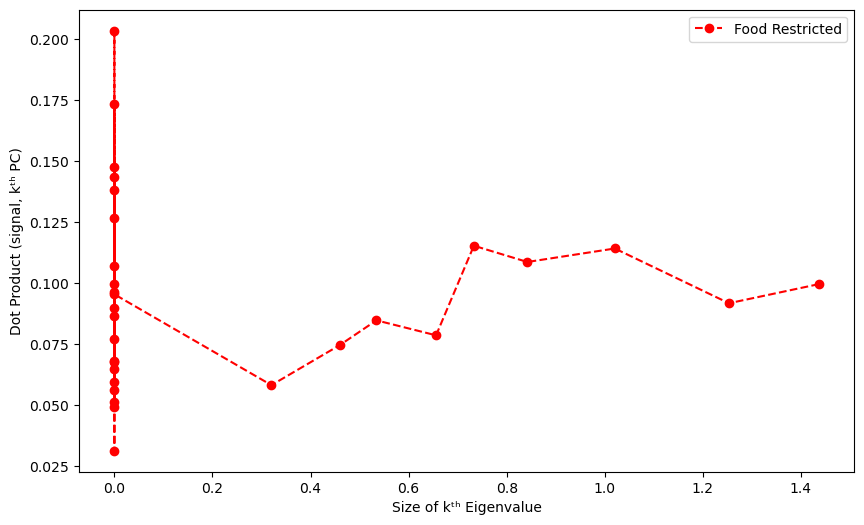

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def extract_plot_vectors(metrics_list, total_k):
    """
    From a single metric dict, build arrays:
      evals_plot : (1, total_k)
      dots_plot  : (1, total_k)
      dist_plot  : (1,)
    """
    # top eigenvalues: shape (n_angles, total_k)
    te = metrics_list['top_evals']
    evals_plot = np.nanmean(te, axis=0, keepdims=True)  # (1, total_k)

    # dot products: shape (n_angles, n_angles-1, total_k)
    dp = metrics_list['dot_prod']
    dp_avg = np.nanmean(dp, axis=0)  # (n_angles-1, total_k)
    dots_plot = dp_avg[0, :][None, :]  # (1, total_k)

    # mean distances: shape (n_angles, n_angles-1)
    md = metrics_list['mean_dist']
    md_avg = np.nanmean(md, axis=0)  # (n_angles-1,)
    dist_plot = md_avg[0][None]  # (1,)

    return evals_plot, dots_plot, dist_plot

# Extract for each group
total_k = test_analysis['top_evals'].shape[-1]
fr_evals_plot, fr_dots_plot, fr_dist_plot = extract_plot_vectors(test_analysis, total_k)

# Panel 1: eigenvalue size vs dot product, with across‐animal mean ± SEM
x_fr = np.nanmean(fr_evals_plot, axis=0)
y_fr = np.nanmean(fr_dots_plot, axis=0)
sem_fr = np.nanstd(fr_dots_plot, axis=0, ddof=1) / np.sqrt(fr_dots_plot.shape[0])

plt.figure(figsize=(10, 6))
plt.plot(x_fr, y_fr, 'o--', color='red',   label='Food Restricted')
# plt.fill_between(x_fr, y_fr - sem_fr, y_fr + sem_fr, color='red',   alpha=0.2)
plt.xlabel('Size of kᵗʰ Eigenvalue')
plt.ylabel('Dot Product (signal, kᵗʰ PC)')
plt.legend()


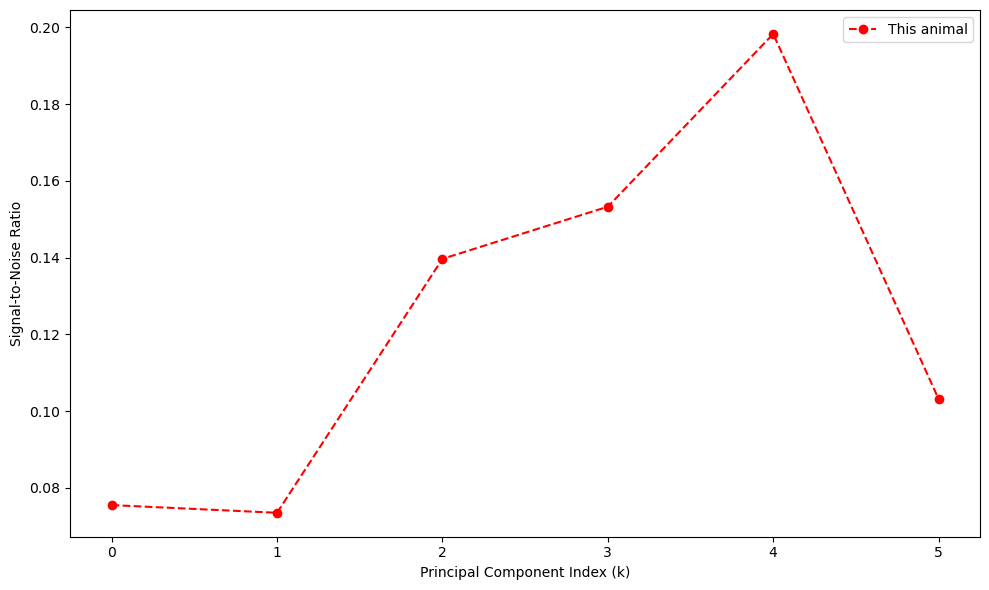

In [42]:
def extract_snr_beta_single(metrics, total_k):
    """
    From a single metric dict, compute arrays:
      snr:  shape (total_k,)
      beta: shape (total_k,)
    with
      snr = (mean_cos)^2 * (mean_dist)^2 / (mean_eval)
      beta = snr / (mean_eval)
    where means are over angles for the closest direction (j=0).
    """
    # top_evals: (n_angles, total_k)
    evals = metrics['top_evals']
    mean_eval = np.nanmean(evals, axis=0)  # (total_k,)

    # dot_prod: (n_angles, n_angles-1, total_k)
    cosines = metrics['dot_prod'][:, 0, :]        # (n_angles, total_k)
    mean_cos = np.nanmean(cosines, axis=0)        # (total_k,)

    # mean_dist: (n_angles, n_angles-1)
    dists = metrics['mean_dist'][:, 0]            # (n_angles,)
    mean_dist = np.nanmean(dists)                 # scalar

    snr = (mean_cos**2) * (mean_dist**2) / mean_eval
    beta = snr / mean_eval
    return snr, beta

snr, beta = extract_snr_beta_single(test_analysis, total_k)

x = np.arange(min(6, total_k))

plt.figure(figsize=(10,6))
plt.plot(x, snr[x], 'o--', color='red', label='This animal')
plt.xlabel('Principal Component Index (k)')
plt.ylabel('Signal‐to‐Noise Ratio')
plt.legend()
plt.tight_layout()
